In [1]:
import sys
sys.path.insert(0, "..")

from src.commons.dataset import TinyImageNetDataset
from src.commons.constants import DATA_PATH, DIR_SEP

import logging, os

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import vit_pytorch as vit
from tqdm import tqdm

In [2]:
logging.getLogger().setLevel(logging.INFO)

In [3]:
# Load model
# https://github.com/lucidrains/vit-pytorch#parameters


# Define training parameters
BATCH_SIZE = 256
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
CHECKPOINT_PATH = ".." + DIR_SEP + os.path.join("src", "commons", "models")
print("CHECKPOINT PATH: ", CHECKPOINT_PATH)

# Instantiate model, optimizer and loss function
model = vit.SimpleViT(
    image_size = 64,
    patch_size = 4,
    num_classes = 200,
    dim = 256,
    depth = 2,
    heads = 8,
    mlp_dim = 512
)

print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) :.2e}")

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

# Instantiate dataset
transf = transforms.Lambda(lambda T: T.long()/255)
dataset = TinyImageNetDataset(".." + DIR_SEP + DATA_PATH, transforms=transf)
print(f"Dataset size: {len(dataset)}")

# Split dataset in train/test/validation sets

train_data, test_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

# Create dataloaders

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# Attempt training on GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

# Send to device
model = model.to(DEVICE)
print(torch.cuda.memory_summary())

CHECKPOINT PATH:  ..\src\commons\models
Total parameters: 1.64e+06
Dataset size: 100000
DEVICE: cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |   

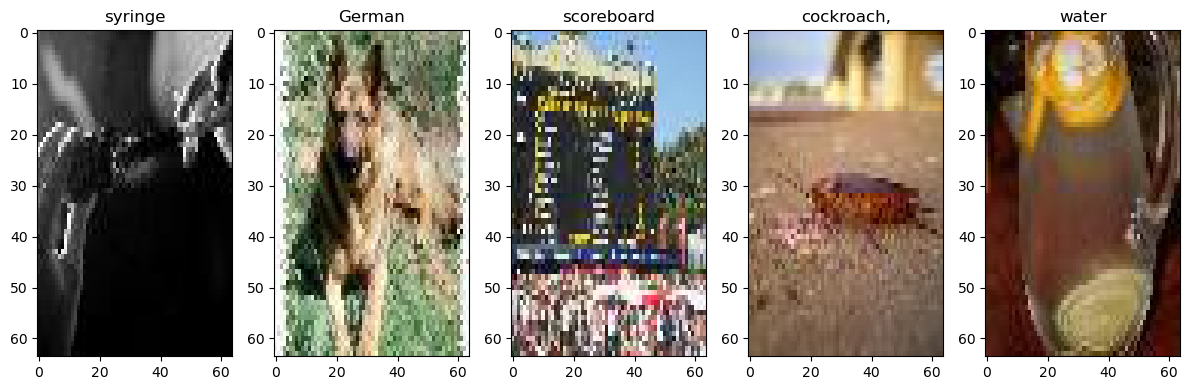

In [4]:
# Check data format

temp_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

sample = next(iter(temp_loader))
img, img_label = sample["inputs"], sample["targets"]

fig, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    img_perm = torch.permute(img[i], (1, 2, 0)).numpy()
    ax[i].imshow(img_perm, aspect="auto")
    title = dataset.index_to_name[img_label[i].item()]
    title = title.split()
    ax[i].set_title(title[0] if isinstance(title, list) else title)
fig.tight_layout()

In [5]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.CrossEntropyLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss, avg_acc = 0., 0.
    for i, batch in pbar:

        data, targets = batch["inputs"], batch["targets"]
        data, targets = data.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits = model(data)
            preds = torch.softmax(logits)
            pred_cats = preds.argmax(dim=1)
            acc = (pred_cats == targets).float().mean()
           
        loss = loss_fn(logits, targets)
        avg_loss += loss.item()
        avg_acc += acc.item()
        pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
    avg_loss /= len(data_loader)
    avg_acc /= len(data_loader)
    return avg_loss, avg_acc

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.CrossEntropyLoss())
    device = kwargs.get("device", torch.device("cpu"))
    num_epochs = kwargs.get("num_epochs", 100)

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss, train_acc = 0., 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            data, targets = batch["inputs"], batch["targets"]
            data, targets = data.to(device), targets.to(device)
    
            logging.debug(f"Batch - Input: {data.shape, type(data)} Target: {targets.shape, type(targets)}")

            model.zero_grad() # initialize gradients to zero
            logits = model(data) # forward pass

            logging.debug(f"Logits - {logits.shape}, {type(logits)}")

            loss = loss_fn(logits, targets) # loss computation
            loss.backward() # computing gradients (backward pass)
            
            optimizer.step() # updating the parameters of the model
            # accuracy computation
            with torch.no_grad():
                preds = torch.softmax(logits)
                pred_cats = preds.argmax(dim=1)
                acc = (pred_cats == targets).float().mean()
    
            # pop computational graph
            train_loss += loss.item()
            train_acc += acc.item() 
            pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
        

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Train loss: {train_loss:.3f} | train acc = {train_acc:.3f}")
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc) 
        
        val_loss, val_acc = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f} | val acc = {val_acc:.3f}")
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

In [6]:
# Training
train_loss, val_loss, train_acc, val_acc = fit(model, train_loader, valid_loader, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)


Epoch 1/50


  0%|          | 0/313 [00:32<?, ?it/s]


KeyboardInterrupt: 

In [5]:
img = torch.randn(5, 3, 64, 64).to(DEVICE)

preds = model(img) 
pred_cat = preds.argmax(dim=1)

In [49]:
torch.addmm?

Docstring:
addmm(input, mat1, mat2, *, beta=1, alpha=1, out=None) -> Tensor

Performs a matrix multiplication of the matrices :attr:`mat1` and :attr:`mat2`.
The matrix :attr:`input` is added to the final result.

If :attr:`mat1` is a :math:`(n \times m)` tensor, :attr:`mat2` is a
:math:`(m \times p)` tensor, then :attr:`input` must be
:ref:`broadcastable <broadcasting-semantics>` with a :math:`(n \times p)` tensor
and :attr:`out` will be a :math:`(n \times p)` tensor.

:attr:`alpha` and :attr:`beta` are scaling factors on matrix-vector product between
:attr:`mat1` and :attr:`mat2` and the added matrix :attr:`input` respectively.

.. math::
    \text{out} = \beta\ \text{input} + \alpha\ (\text{mat1}_i \mathbin{@} \text{mat2}_i)

If :attr:`beta` is 0, then :attr:`input` will be ignored, and `nan` and `inf` in
it will not be propagated.

For inputs of type `FloatTensor` or `DoubleTensor`, arguments :attr:`beta` and
:attr:`alpha` must be real numbers, otherwise they should be integers.

Th